# Timeseries analysis

This notebook analyzes the National Water Model timeseries. Our previous notebook used datasets that were chunked in time, which enables fast access to a temporal snapshot of the entire Continental United States. For this notebook, we'll used a *rechunked* dataset that's (primarily) chunked in space.

In [ ]:
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns

storage_options = {"account_name": "noaanwm"}

In [2]:
ds = xr.open_dataset(
    "az://ciroh/zarr/ts/short-range-forcing-rechunked-test.zarr",
    engine="zarr",
    consolidated=True,
    storage_options=storage_options,
    chunks={},
    decode_cf="all",
)
crs = pyproj.CRS.from_cf(ds.crs.attrs)
ds = ds.rio.write_crs(crs)
ds

<xarray.Dataset>
Dimensions:         (time: 7306, y: 3840, x: 4608, reference_time: 1)
Coordinates:
    crs             int64 0
  * reference_time  (reference_time) datetime64[ns] 2023-04-27T11:00:00
  * time            (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(168, 240, 288), meta=np.ndarray>
Attributes:
    NWM_version_number:         v2.2
    model_configuration:        short_range
    model_initialization_time:  2023-04-27_11:00:00
    model_output_type:          forcing
    model_output_valid_time:    2023-04-27_12:00:00
    model_total_valid_times:    18
    pangeo-forge:inputs_hash:   59784c1feed1b881dc936b070ac5a83cbc680599cb9b6...
    pangeo-forge:recipe_hash:   25e9980cd34a6a0871883fc7375f224d34f403c944f95...
    pangeo-forge:version:       0.9.4

We'll extract a timeseries for a small region of data.

In [3]:
# Get the state boundary for Iowa
import pystac_client
import planetary_computer
import geopandas

catalog = pystac_client.Client.open(
    "http://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("us-census")

counties = collection.get_item("2020-cb_2020_us_county_500k").assets["data"]

df = geopandas.read_parquet(
    counties.href,
    storage_options=counties.extra_fields["table:storage_options"],
    columns=["NAME", "STATE_NAME", "geometry"],
)
df

,NAME,STATE_NAME,geometry
0,Logan,Kentucky,"POLYGON ((-87.06037 36.68085, -87.06002 36.708..."
1,Queens,New York,"POLYGON ((-73.96262 40.73903, -73.96243 40.739..."
2,Hudson,New Jersey,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ..."
3,Hunterdon,New Jersey,"POLYGON ((-75.19511 40.57969, -75.19466 40.581..."
4,McCreary,Kentucky,"POLYGON ((-84.77845 36.60329, -84.73068 36.665..."
...,...,...,...
3229,Broomfield,Colorado,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073..."
3230,Washington,Colorado,"POLYGON ((-103.70655 39.73989, -103.70655 39.7..."
3231,Dakota,Minnesota,"POLYGON ((-93.32967 44.77948, -93.32962 44.791..."
3232,Sheridan,Nebraska,"POLYGON ((-102.79287 42.82249, -102.79211 42.9..."


In [4]:
geom = df.loc[(df.NAME == "Polk") & (df.STATE_NAME == "Iowa"), "geometry"].item()

In [5]:
ts = ds.rio.clip([geom.simplify(0.1)], crs="epsg:4326")
ts

<xarray.Dataset>
Dimensions:   (time: 7306, x: 41, y: 40)
Coordinates:
  * time      (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
  * x         (x) float64 2.555e+05 2.565e+05 2.575e+05 ... 2.945e+05 2.955e+05
  * y         (y) float64 1.675e+05 1.685e+05 1.695e+05 ... 2.055e+05 2.065e+05
    crs       int64 0
Data variables:
    LWDOWN    (time, y, x) float64 dask.array<chunksize=(168, 40, 33), meta=np.ndarray>
    PSFC      (time, y, x) float64 dask.array<chunksize=(168, 40, 33), meta=np.ndarray>
    Q2D       (time, y, x) float64 dask.array<chunksize=(168, 40, 33), meta=np.ndarray>
    RAINRATE  (time, y, x) float32 dask.array<chunksize=(168, 40, 33), meta=np.ndarray>
    SWDOWN    (time, y, x) float64 dask.array<chunksize=(168, 40, 33), meta=np.ndarray>
    T2D       (time, y, x) float64 dask.array<chunksize=(168, 40, 33), meta=np.ndarray>
    U2D       (time, y, x) float64 dask.array<chunksize=(168, 40, 33), meta=np.ndarray>
    V2D       (time, y, x) float64 dask.array<chunksize=(168, 40, 33), meta=np.ndarray>
Attributes:
    NWM_version_number:         v2.2
    model_configuration:        short_range
    model_initialization_time:  2023-04-27_11:00:00
    model_output_type:          forcing
    model_output_valid_time:    2023-04-27_12:00:00
    model_total_valid_times:    18
    pangeo-forge:inputs_hash:   59784c1feed1b881dc936b070ac5a83cbc680599cb9b6...
    pangeo-forge:recipe_hash:   25e9980cd34a6a0871883fc7375f224d34f403c944f95...
    pangeo-forge:version:       0.9.4

Accessing a single timestamp of data from this subset is fast:

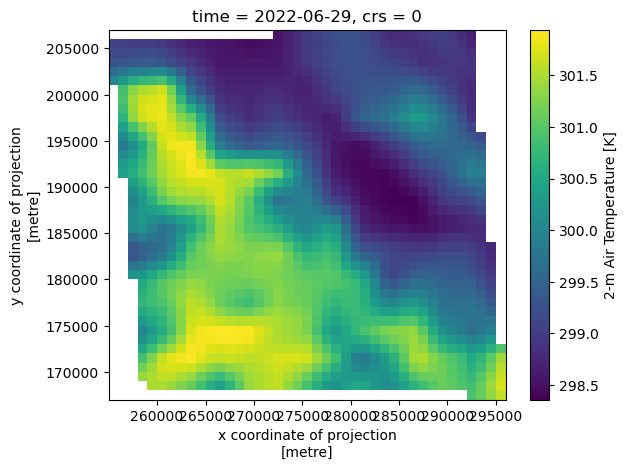

In [6]:
ts.T2D.isel(time=0).plot();

Accessing data through time is also relatively fast (compared to using the dataset that's chunked in time).

In [7]:
from distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/taugspurger/proxy/8787/status,
Dashboard: /user/taugspurger/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 7.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43703,Workers: 4
Dashboard: /user/taugspurger/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 7.50 GiB
Comm: tcp://127.0.0.1:42313,Total threads: 2
Dashboard: /user/taugspurger/proxy/43171/status,Memory: 1.88 GiB
Nanny: tcp://127.0.0.1:37837,


In [8]:
t = ts[["RAINRATE", "T2D"]].mean(dim=("y", "x")).compute()

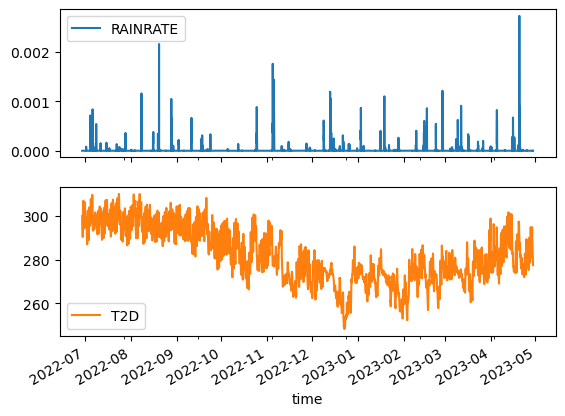

In [9]:
t.to_dataframe()[["RAINRATE", "T2D"]].plot(subplots=True);

In [10]:
client.close()

Now let's do a fun computation. We'll calculate an average temperature at each hour, and look at the difference (anomaly?) from it over the course of our timeseries.

In [11]:
240 * 12, 288 * 12

(2880, 3456)

In [12]:
subset = ds["T2D"].isel(y=slice(2400, 2880), x=slice(2880, 3456))
subset

<xarray.DataArray 'T2D' (time: 7306, y: 480, x: 576)>
dask.array<getitem, shape=(7306, 480, 576), dtype=float64, chunksize=(168, 240, 288), chunktype=numpy.ndarray>
Coordinates:
    crs      int64 0
  * time     (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
  * x        (x) float64 5.765e+05 5.775e+05 5.785e+05 ... 1.151e+06 1.152e+06
  * y        (y) float64 4.805e+05 4.815e+05 4.825e+05 ... 9.585e+05 9.595e+05
Attributes:
    cell_methods:    time: point
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       2-m Air Temperature
    proj4:           +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0...
    remap:           remapped via ESMF regrid_with_weights: Bilinear
    standard_name:   air_temperature
    units:           K

In [13]:
hourly = subset.groupby("time.hour").mean(dim="time")
hourly

<xarray.DataArray 'T2D' (hour: 24, y: 480, x: 576)>
dask.array<transpose, shape=(24, 480, 576), dtype=float64, chunksize=(24, 240, 288), chunktype=numpy.ndarray>
Coordinates:
    crs      int64 0
  * x        (x) float64 5.765e+05 5.775e+05 5.785e+05 ... 1.151e+06 1.152e+06
  * y        (y) float64 4.805e+05 4.815e+05 4.825e+05 ... 9.585e+05 9.595e+05
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Attributes:
    cell_methods:    time: point
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       2-m Air Temperature
    proj4:           +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0...
    remap:           remapped via ESMF regrid_with_weights: Bilinear
    standard_name:   air_temperature
    units:           K

This is a relatively large computation. We'll distribute it on a cluster of machines.

In [14]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/default.ff91e3c04f4a46b8a52373ef681d833e/status,


We'll use this result in a computation later on, so let's persist it on the cluster.

In [15]:
hourly = hourly.persist()

And peek at the first timestamp.

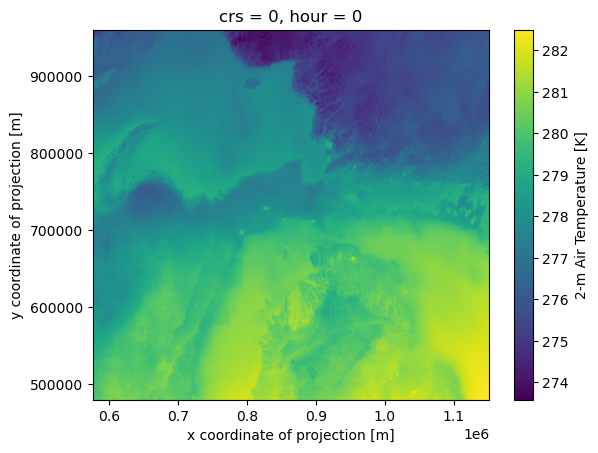

In [16]:
hourly.isel(hour=0).plot();

Now we can calculate the anomaly.

In [17]:
import dask

with dask.config.set(**{"array.slicing.split_large_chunks": True}):
    anomaly = subset.groupby("time.hour") - hourly
anomaly

<xarray.DataArray 'T2D' (time: 7306, y: 480, x: 576)>
dask.array<sub, shape=(7306, 480, 576), dtype=float64, chunksize=(168, 240, 288), chunktype=numpy.ndarray>
Coordinates:
    crs      (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * time     (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
  * x        (x) float64 5.765e+05 5.775e+05 5.785e+05 ... 1.151e+06 1.152e+06
  * y        (y) float64 4.805e+05 4.815e+05 4.825e+05 ... 9.585e+05 9.595e+05
    hour     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 ... 0 1 2 3 4 5 6 7 8 9 10

In [18]:
avg = anomaly.mean(dim=("y", "x"))
avg

<xarray.DataArray 'T2D' (time: 7306)>
dask.array<mean_agg-aggregate, shape=(7306,), dtype=float64, chunksize=(168,), chunktype=numpy.ndarray>
Coordinates:
    crs      (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * time     (time) datetime64[ns] 2022-06-29 ... 2023-04-29T10:00:00
    hour     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 ... 0 1 2 3 4 5 6 7 8 9 10

This is a small result, so we can bring it back to the client with `.compute()`.

In [19]:
avg = avg.compute()

And visualize the result.

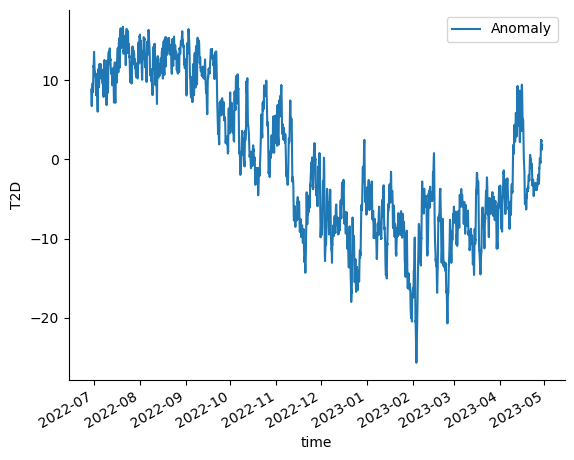

2023-05-14 01:56:53,273 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [22]:
fig, ax = plt.subplots()
avg.plot(label="Anomaly", ax=ax)
ax.legend()
sns.despine()